In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))
# TensorFlow and tf.keras
import tensorflow as tf
import tensorflow_addons as tfa
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from sklearn.metrics import confusion_matrix
import seaborn as sns

from datetime import datetime

print(tf.__version__)
tf.config.list_physical_devices('GPU')
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2.9.1
1 Physical GPUs, 1 Logical GPUs


2022-11-19 11:56:22.548733: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 11:56:22.552758: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 11:56:22.552938: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 11:56:22.553980: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [2]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    accuracy = training_history.history['sparse_categorical_accuracy']
    val_accuracy = training_history.history['val_sparse_categorical_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.savefig(fname="convolutedRGB/convolutedRGB history"+current_time,dpi=300)

In [3]:
(ds_train, ds_test, ds_validation), ds_info = tfds.load(
    'eurosat/all',
    split=['train[:80%]','train[80%:90%]','train[90%:100%]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [4]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return image[:,:,1:4]/28002., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.cache()
ds_test = ds_test.batch(128)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

ds_validation = ds_validation.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_validation = ds_validation.batch(128)
ds_validation = ds_validation.cache()

In [5]:
#FLIP
def augment_flip(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image
# AUGMENT COLOR
def augment_color(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_hue(image, max_delta=0.08)
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    image = tf.image.random_brightness(image, 0.07)
    image = tf.image.random_contrast(image, lower=0.8, upper=1)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image
def augment_hue(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_hue(image, max_delta=0.062)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image
def augment_saturation(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_saturation(image, lower=0.745, upper=1.25)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image
def augment_brightness(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_brightness(image, 0.062)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image
def augment_contrast(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_contrast(image, lower=0.85, upper=1.05)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image
# ROTATE
def augment_rotation(image: tf.Tensor) -> tf.Tensor:
    # Rotate 0, 90, 180, 270 degrees
    return tf.image.rot90(
        image,
        tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    )
#INVERT
def augment_inversion(image: tf.Tensor) -> tf.Tensor:
    random = tf.random.uniform(shape=[], minval=0, maxval=1)
    if random > 0.8:
        image = tf.math.multiply(image, -1)
        image = tf.math.add(image, 1)
    return image

In [6]:
def augment_data(image,label):
  image=augment_flip(image)
  #image=augment_color(image)
  #image=augment_rotation(image)
  #image=augment_inversion(image)
  image=augment_hue(image)
  image=augment_saturation(image)
  image=augment_brightness(image)
  image=augment_contrast(image)


  return image,label

In [7]:
ds_train_augmented = ds_train.map(augment_data)

In [8]:
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    #elif epoch < 10:
    #    return lr * tf.math.exp(-0.25)
    elif epoch < 100:
        return lr * tf.math.exp(-0.01)
    elif epoch < 200:
        return lr * tf.math.exp(-0.0005)
    else:
        return lr

In [9]:
image_shape = (64,64,3)
model = tf.keras.models.Sequential([
    tf.keras.layers.Convolution2D(input_shape=image_shape,filters=32,kernel_size=2,strides=(1,1),activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(1,1)),
    tf.keras.layers.Convolution2D(input_shape=image_shape,filters=32,kernel_size=2,strides=(1,1),activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    tf.keras.layers.Convolution2D(input_shape=image_shape,filters=64,kernel_size=3,strides=(1,1),activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(1,1)),
    tf.keras.layers.Convolution2D(input_shape=image_shape,filters=128,kernel_size=3,strides=(2,2),activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])




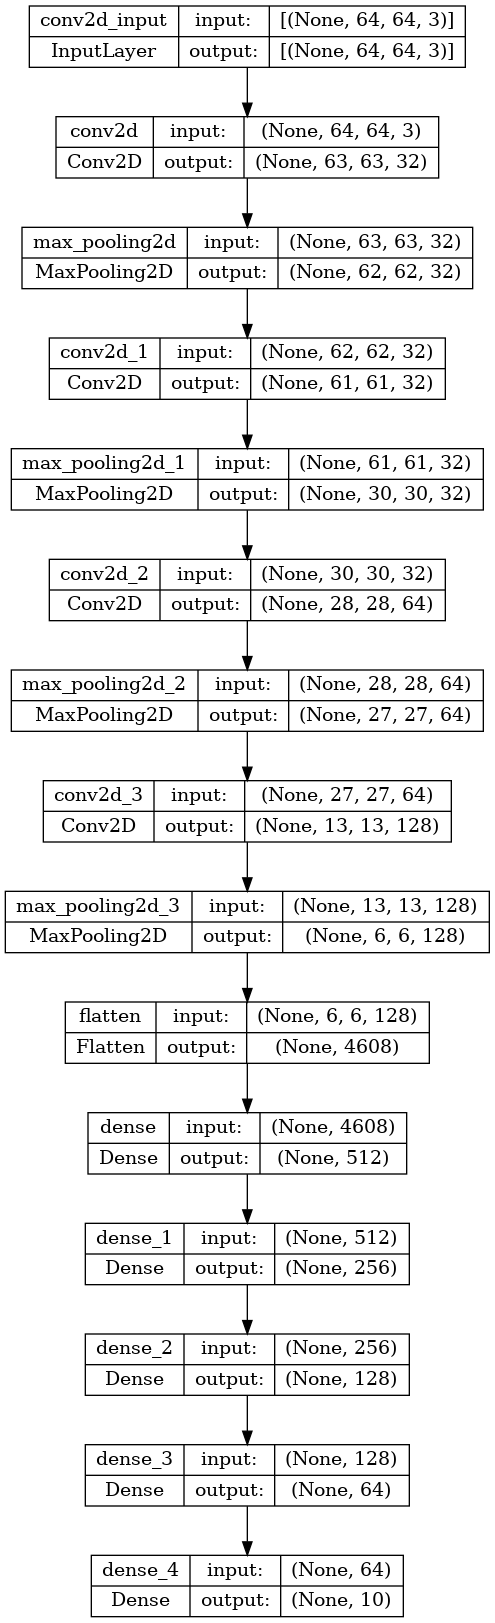

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.00005),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=True)

In [11]:
history= model.fit(
    ds_train,
    epochs=800,
    validation_data=ds_validation,
    callbacks = [tf.keras.callbacks.ModelCheckpoint(
        "convolutedRGB/convolutedRGB epoch:{epoch:02d}-val_loss:{val_loss:.3f}",
        save_best_only = True,
        initial_value_threshold = 0.5
    )
    ,tf.keras.callbacks.LearningRateScheduler(scheduler)
    ]
)

Epoch 1/800


2022-11-19 11:56:25.749498: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


169/169 [==============================] - 9s 37ms/step - loss: 2.0993 - sparse_categorical_accuracy: 0.2019 - val_loss: 1.7317 - val_sparse_categorical_accuracy: 0.2885 - lr: 5.0000e-05
Epoch 2/800
169/169 [==============================] - 6s 34ms/step - loss: 1.6328 - sparse_categorical_accuracy: 0.3577 - val_loss: 1.5449 - val_sparse_categorical_accuracy: 0.3663 - lr: 5.0000e-05
Epoch 3/800
169/169 [==============================] - 6s 35ms/step - loss: 1.4620 - sparse_categorical_accuracy: 0.4473 - val_loss: 1.3211 - val_sparse_categorical_accuracy: 0.4770 - lr: 5.0000e-05
Epoch 4/800
169/169 [==============================] - 6s 35ms/step - loss: 1.2371 - sparse_categorical_accuracy: 0.5281 - val_loss: 1.1598 - val_sparse_categorical_accuracy: 0.5459 - lr: 5.0000e-05
Epoch 5/800
169/169 [==============================] - 6s 34ms/step - loss: 1.1434 - sparse_categorical_accuracy: 0.5595 - val_loss: 1.1028 - val_sparse_categorical_accuracy: 0.5733 - lr: 5.0000e-05
Epoch 6/800
169/1

169/169 [==============================] - 6s 35ms/step - loss: 0.6270 - sparse_categorical_accuracy: 0.7673 - val_loss: 0.6120 - val_sparse_categorical_accuracy: 0.7822 - lr: 3.4537e-05
Epoch 43/800
169/169 [==============================] - 6s 35ms/step - loss: 0.6201 - sparse_categorical_accuracy: 0.7701 - val_loss: 0.6335 - val_sparse_categorical_accuracy: 0.7741 - lr: 3.4193e-05
Epoch 44/800
169/169 [==============================] - 6s 35ms/step - loss: 0.6206 - sparse_categorical_accuracy: 0.7678 - val_loss: 0.6150 - val_sparse_categorical_accuracy: 0.7841 - lr: 3.3853e-05
Epoch 45/800
169/169 [==============================] - 6s 35ms/step - loss: 0.6147 - sparse_categorical_accuracy: 0.7712 - val_loss: 0.6389 - val_sparse_categorical_accuracy: 0.7681 - lr: 3.3516e-05
Epoch 46/800
169/169 [==============================] - 6s 34ms/step - loss: 0.6171 - sparse_categorical_accuracy: 0.7685 - val_loss: 0.6122 - val_sparse_categorical_accuracy: 0.7837 - lr: 3.3183e-05
Epoch 47/800


169/169 [==============================] - 6s 35ms/step - loss: 0.5317 - sparse_categorical_accuracy: 0.8048 - val_loss: 0.5473 - val_sparse_categorical_accuracy: 0.8000 - lr: 2.2920e-05
Epoch 84/800
169/169 [==============================] - 6s 35ms/step - loss: 0.5216 - sparse_categorical_accuracy: 0.8100 - val_loss: 0.5464 - val_sparse_categorical_accuracy: 0.8037 - lr: 2.2692e-05
Epoch 85/800
169/169 [==============================] - 6s 35ms/step - loss: 0.5234 - sparse_categorical_accuracy: 0.8067 - val_loss: 0.5348 - val_sparse_categorical_accuracy: 0.8111 - lr: 2.2466e-05
Epoch 86/800
169/169 [==============================] - 6s 35ms/step - loss: 0.5244 - sparse_categorical_accuracy: 0.8090 - val_loss: 0.5498 - val_sparse_categorical_accuracy: 0.7959 - lr: 2.2243e-05
Epoch 87/800
169/169 [==============================] - 6s 35ms/step - loss: 0.5140 - sparse_categorical_accuracy: 0.8145 - val_loss: 0.5347 - val_sparse_categorical_accuracy: 0.8063 - lr: 2.2022e-05
Epoch 88/800


INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:117-val_loss:0.499/assets


INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:117-val_loss:0.499/assets


169/169 [==============================] - 7s 40ms/step - loss: 0.4771 - sparse_categorical_accuracy: 0.8250 - val_loss: 0.4993 - val_sparse_categorical_accuracy: 0.8267 - lr: 1.9173e-05
Epoch 118/800
169/169 [==============================] - 6s 35ms/step - loss: 0.4741 - sparse_categorical_accuracy: 0.8274 - val_loss: 0.5058 - val_sparse_categorical_accuracy: 0.8181 - lr: 1.9164e-05
Epoch 119/800
169/169 [==============================] - 6s 35ms/step - loss: 0.4753 - sparse_categorical_accuracy: 0.8283 - val_loss: 0.5033 - val_sparse_categorical_accuracy: 0.8207 - lr: 1.9154e-05
Epoch 120/800
169/169 [==============================] - 6s 35ms/step - loss: 0.4757 - sparse_categorical_accuracy: 0.8242 - val_loss: 0.5114 - val_sparse_categorical_accuracy: 0.8189 - lr: 1.9145e-05
Epoch 121/800
169/169 [==============================] - 6s 35ms/step - loss: 0.4720 - sparse_categorical_accuracy: 0.8285 - val_loss: 0.5101 - val_sparse_categorical_accuracy: 0.8222 - lr: 1.9135e-05
Epoch 122

INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:132-val_loss:0.493/assets


INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:132-val_loss:0.493/assets


169/169 [==============================] - 7s 40ms/step - loss: 0.4556 - sparse_categorical_accuracy: 0.8340 - val_loss: 0.4931 - val_sparse_categorical_accuracy: 0.8296 - lr: 1.9030e-05
Epoch 133/800
169/169 [==============================] - ETA: 0s - loss: 0.4594 - sparse_categorical_accuracy: 0.8337

INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:133-val_loss:0.487/assets


INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:133-val_loss:0.487/assets


169/169 [==============================] - 7s 40ms/step - loss: 0.4594 - sparse_categorical_accuracy: 0.8337 - val_loss: 0.4868 - val_sparse_categorical_accuracy: 0.8304 - lr: 1.9021e-05
Epoch 134/800
169/169 [==============================] - 6s 35ms/step - loss: 0.4549 - sparse_categorical_accuracy: 0.8344 - val_loss: 0.5306 - val_sparse_categorical_accuracy: 0.8107 - lr: 1.9011e-05
Epoch 135/800
169/169 [==============================] - 6s 35ms/step - loss: 0.4634 - sparse_categorical_accuracy: 0.8319 - val_loss: 0.4895 - val_sparse_categorical_accuracy: 0.8270 - lr: 1.9002e-05
Epoch 136/800
169/169 [==============================] - 6s 35ms/step - loss: 0.4533 - sparse_categorical_accuracy: 0.8349 - val_loss: 0.5196 - val_sparse_categorical_accuracy: 0.8089 - lr: 1.8992e-05
Epoch 137/800
169/169 [==============================] - 6s 35ms/step - loss: 0.4618 - sparse_categorical_accuracy: 0.8315 - val_loss: 0.4960 - val_sparse_categorical_accuracy: 0.8270 - lr: 1.8983e-05
Epoch 138

INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:138-val_loss:0.482/assets


INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:138-val_loss:0.482/assets


169/169 [==============================] - 7s 40ms/step - loss: 0.4486 - sparse_categorical_accuracy: 0.8388 - val_loss: 0.4821 - val_sparse_categorical_accuracy: 0.8319 - lr: 1.8973e-05
Epoch 139/800
169/169 [==============================] - 6s 35ms/step - loss: 0.4561 - sparse_categorical_accuracy: 0.8357 - val_loss: 0.5021 - val_sparse_categorical_accuracy: 0.8193 - lr: 1.8964e-05
Epoch 140/800
169/169 [==============================] - ETA: 0s - loss: 0.4498 - sparse_categorical_accuracy: 0.8372

INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:140-val_loss:0.479/assets


INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:140-val_loss:0.479/assets


169/169 [==============================] - 7s 40ms/step - loss: 0.4498 - sparse_categorical_accuracy: 0.8372 - val_loss: 0.4795 - val_sparse_categorical_accuracy: 0.8352 - lr: 1.8954e-05
Epoch 141/800
169/169 [==============================] - 6s 34ms/step - loss: 0.4471 - sparse_categorical_accuracy: 0.8377 - val_loss: 0.4913 - val_sparse_categorical_accuracy: 0.8256 - lr: 1.8945e-05
Epoch 142/800
169/169 [==============================] - 6s 35ms/step - loss: 0.4472 - sparse_categorical_accuracy: 0.8396 - val_loss: 0.4838 - val_sparse_categorical_accuracy: 0.8348 - lr: 1.8935e-05
Epoch 143/800
169/169 [==============================] - 6s 35ms/step - loss: 0.4438 - sparse_categorical_accuracy: 0.8407 - val_loss: 0.5039 - val_sparse_categorical_accuracy: 0.8252 - lr: 1.8926e-05
Epoch 144/800
169/169 [==============================] - ETA: 0s - loss: 0.4449 - sparse_categorical_accuracy: 0.8390

INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:144-val_loss:0.476/assets


INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:144-val_loss:0.476/assets


169/169 [==============================] - 7s 40ms/step - loss: 0.4449 - sparse_categorical_accuracy: 0.8390 - val_loss: 0.4760 - val_sparse_categorical_accuracy: 0.8352 - lr: 1.8916e-05
Epoch 145/800
169/169 [==============================] - 6s 34ms/step - loss: 0.4454 - sparse_categorical_accuracy: 0.8391 - val_loss: 0.4825 - val_sparse_categorical_accuracy: 0.8333 - lr: 1.8907e-05
Epoch 146/800
169/169 [==============================] - 6s 35ms/step - loss: 0.4431 - sparse_categorical_accuracy: 0.8400 - val_loss: 0.4974 - val_sparse_categorical_accuracy: 0.8181 - lr: 1.8897e-05
Epoch 147/800
169/169 [==============================] - 6s 35ms/step - loss: 0.4429 - sparse_categorical_accuracy: 0.8409 - val_loss: 0.4888 - val_sparse_categorical_accuracy: 0.8285 - lr: 1.8888e-05
Epoch 148/800
169/169 [==============================] - 6s 35ms/step - loss: 0.4407 - sparse_categorical_accuracy: 0.8406 - val_loss: 0.5065 - val_sparse_categorical_accuracy: 0.8215 - lr: 1.8879e-05
Epoch 149

INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:153-val_loss:0.472/assets


INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:153-val_loss:0.472/assets


169/169 [==============================] - 7s 40ms/step - loss: 0.4435 - sparse_categorical_accuracy: 0.8407 - val_loss: 0.4724 - val_sparse_categorical_accuracy: 0.8378 - lr: 1.8831e-05
Epoch 154/800
169/169 [==============================] - 6s 35ms/step - loss: 0.4370 - sparse_categorical_accuracy: 0.8434 - val_loss: 0.4753 - val_sparse_categorical_accuracy: 0.8356 - lr: 1.8822e-05
Epoch 155/800
169/169 [==============================] - 6s 35ms/step - loss: 0.4332 - sparse_categorical_accuracy: 0.8431 - val_loss: 0.4737 - val_sparse_categorical_accuracy: 0.8378 - lr: 1.8813e-05
Epoch 156/800
169/169 [==============================] - 6s 35ms/step - loss: 0.4307 - sparse_categorical_accuracy: 0.8449 - val_loss: 0.4907 - val_sparse_categorical_accuracy: 0.8296 - lr: 1.8803e-05
Epoch 157/800
169/169 [==============================] - 6s 35ms/step - loss: 0.4378 - sparse_categorical_accuracy: 0.8404 - val_loss: 0.4745 - val_sparse_categorical_accuracy: 0.8304 - lr: 1.8794e-05
Epoch 158

INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:162-val_loss:0.470/assets


INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:162-val_loss:0.470/assets


169/169 [==============================] - 7s 40ms/step - loss: 0.4301 - sparse_categorical_accuracy: 0.8452 - val_loss: 0.4703 - val_sparse_categorical_accuracy: 0.8367 - lr: 1.8747e-05
Epoch 163/800
169/169 [==============================] - 6s 35ms/step - loss: 0.4283 - sparse_categorical_accuracy: 0.8462 - val_loss: 0.4967 - val_sparse_categorical_accuracy: 0.8200 - lr: 1.8737e-05
Epoch 164/800
169/169 [==============================] - 6s 35ms/step - loss: 0.4244 - sparse_categorical_accuracy: 0.8465 - val_loss: 0.5017 - val_sparse_categorical_accuracy: 0.8211 - lr: 1.8728e-05
Epoch 165/800
169/169 [==============================] - 6s 35ms/step - loss: 0.4285 - sparse_categorical_accuracy: 0.8446 - val_loss: 0.4846 - val_sparse_categorical_accuracy: 0.8237 - lr: 1.8719e-05
Epoch 166/800
169/169 [==============================] - ETA: 0s - loss: 0.4248 - sparse_categorical_accuracy: 0.8459

INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:166-val_loss:0.467/assets


INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:166-val_loss:0.467/assets


169/169 [==============================] - 7s 41ms/step - loss: 0.4248 - sparse_categorical_accuracy: 0.8459 - val_loss: 0.4668 - val_sparse_categorical_accuracy: 0.8356 - lr: 1.8709e-05
Epoch 167/800
169/169 [==============================] - 6s 35ms/step - loss: 0.4248 - sparse_categorical_accuracy: 0.8459 - val_loss: 0.4940 - val_sparse_categorical_accuracy: 0.8289 - lr: 1.8700e-05
Epoch 168/800
169/169 [==============================] - 6s 35ms/step - loss: 0.4232 - sparse_categorical_accuracy: 0.8456 - val_loss: 0.4958 - val_sparse_categorical_accuracy: 0.8222 - lr: 1.8691e-05
Epoch 169/800
169/169 [==============================] - ETA: 0s - loss: 0.4212 - sparse_categorical_accuracy: 0.8492

INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:169-val_loss:0.465/assets


INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:169-val_loss:0.465/assets


169/169 [==============================] - 7s 40ms/step - loss: 0.4212 - sparse_categorical_accuracy: 0.8492 - val_loss: 0.4652 - val_sparse_categorical_accuracy: 0.8393 - lr: 1.8681e-05
Epoch 170/800
169/169 [==============================] - 6s 35ms/step - loss: 0.4235 - sparse_categorical_accuracy: 0.8468 - val_loss: 0.4790 - val_sparse_categorical_accuracy: 0.8259 - lr: 1.8672e-05
Epoch 171/800
169/169 [==============================] - ETA: 0s - loss: 0.4149 - sparse_categorical_accuracy: 0.8530

INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:171-val_loss:0.465/assets


INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:171-val_loss:0.465/assets


169/169 [==============================] - 7s 40ms/step - loss: 0.4149 - sparse_categorical_accuracy: 0.8530 - val_loss: 0.4652 - val_sparse_categorical_accuracy: 0.8415 - lr: 1.8663e-05
Epoch 172/800
169/169 [==============================] - ETA: 0s - loss: 0.4126 - sparse_categorical_accuracy: 0.8518

INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:172-val_loss:0.465/assets


INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:172-val_loss:0.465/assets


169/169 [==============================] - 7s 40ms/step - loss: 0.4126 - sparse_categorical_accuracy: 0.8518 - val_loss: 0.4646 - val_sparse_categorical_accuracy: 0.8381 - lr: 1.8653e-05
Epoch 173/800
169/169 [==============================] - ETA: 0s - loss: 0.4162 - sparse_categorical_accuracy: 0.8497

INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:173-val_loss:0.465/assets


INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:173-val_loss:0.465/assets


169/169 [==============================] - 7s 40ms/step - loss: 0.4162 - sparse_categorical_accuracy: 0.8497 - val_loss: 0.4646 - val_sparse_categorical_accuracy: 0.8396 - lr: 1.8644e-05
Epoch 174/800
169/169 [==============================] - 6s 35ms/step - loss: 0.4136 - sparse_categorical_accuracy: 0.8508 - val_loss: 0.4957 - val_sparse_categorical_accuracy: 0.8259 - lr: 1.8635e-05
Epoch 175/800
169/169 [==============================] - 6s 35ms/step - loss: 0.4190 - sparse_categorical_accuracy: 0.8489 - val_loss: 0.4689 - val_sparse_categorical_accuracy: 0.8374 - lr: 1.8625e-05
Epoch 176/800
169/169 [==============================] - 6s 35ms/step - loss: 0.4137 - sparse_categorical_accuracy: 0.8516 - val_loss: 0.4684 - val_sparse_categorical_accuracy: 0.8385 - lr: 1.8616e-05
Epoch 177/800
169/169 [==============================] - 6s 35ms/step - loss: 0.4212 - sparse_categorical_accuracy: 0.8480 - val_loss: 0.4902 - val_sparse_categorical_accuracy: 0.8222 - lr: 1.8607e-05
Epoch 178

INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:181-val_loss:0.459/assets


INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:181-val_loss:0.459/assets


169/169 [==============================] - 7s 39ms/step - loss: 0.4158 - sparse_categorical_accuracy: 0.8500 - val_loss: 0.4587 - val_sparse_categorical_accuracy: 0.8444 - lr: 1.8570e-05
Epoch 182/800
169/169 [==============================] - 6s 34ms/step - loss: 0.4155 - sparse_categorical_accuracy: 0.8500 - val_loss: 0.4600 - val_sparse_categorical_accuracy: 0.8370 - lr: 1.8560e-05
Epoch 183/800
169/169 [==============================] - 6s 35ms/step - loss: 0.4113 - sparse_categorical_accuracy: 0.8502 - val_loss: 0.4646 - val_sparse_categorical_accuracy: 0.8341 - lr: 1.8551e-05
Epoch 184/800
169/169 [==============================] - 6s 35ms/step - loss: 0.4052 - sparse_categorical_accuracy: 0.8553 - val_loss: 0.4645 - val_sparse_categorical_accuracy: 0.8363 - lr: 1.8542e-05
Epoch 185/800
169/169 [==============================] - 6s 35ms/step - loss: 0.4049 - sparse_categorical_accuracy: 0.8550 - val_loss: 0.4691 - val_sparse_categorical_accuracy: 0.8404 - lr: 1.8532e-05
Epoch 186

INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:187-val_loss:0.455/assets


INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:187-val_loss:0.455/assets


169/169 [==============================] - 7s 40ms/step - loss: 0.4031 - sparse_categorical_accuracy: 0.8555 - val_loss: 0.4554 - val_sparse_categorical_accuracy: 0.8389 - lr: 1.8514e-05
Epoch 188/800
169/169 [==============================] - 6s 35ms/step - loss: 0.4023 - sparse_categorical_accuracy: 0.8561 - val_loss: 0.4594 - val_sparse_categorical_accuracy: 0.8396 - lr: 1.8505e-05
Epoch 189/800
169/169 [==============================] - 6s 35ms/step - loss: 0.4032 - sparse_categorical_accuracy: 0.8544 - val_loss: 0.4690 - val_sparse_categorical_accuracy: 0.8344 - lr: 1.8495e-05
Epoch 190/800
169/169 [==============================] - 6s 35ms/step - loss: 0.4025 - sparse_categorical_accuracy: 0.8568 - val_loss: 0.4634 - val_sparse_categorical_accuracy: 0.8337 - lr: 1.8486e-05
Epoch 191/800
169/169 [==============================] - 6s 35ms/step - loss: 0.3981 - sparse_categorical_accuracy: 0.8568 - val_loss: 0.4801 - val_sparse_categorical_accuracy: 0.8356 - lr: 1.8477e-05
Epoch 192

INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:196-val_loss:0.454/assets


INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:196-val_loss:0.454/assets


169/169 [==============================] - 7s 41ms/step - loss: 0.3951 - sparse_categorical_accuracy: 0.8581 - val_loss: 0.4542 - val_sparse_categorical_accuracy: 0.8459 - lr: 1.8431e-05
Epoch 197/800
169/169 [==============================] - 6s 35ms/step - loss: 0.4008 - sparse_categorical_accuracy: 0.8574 - val_loss: 0.4553 - val_sparse_categorical_accuracy: 0.8437 - lr: 1.8422e-05
Epoch 198/800
169/169 [==============================] - ETA: 0s - loss: 0.3909 - sparse_categorical_accuracy: 0.8599

INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:198-val_loss:0.453/assets


INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:198-val_loss:0.453/assets


169/169 [==============================] - 7s 40ms/step - loss: 0.3909 - sparse_categorical_accuracy: 0.8599 - val_loss: 0.4527 - val_sparse_categorical_accuracy: 0.8448 - lr: 1.8412e-05
Epoch 199/800
169/169 [==============================] - 6s 35ms/step - loss: 0.4048 - sparse_categorical_accuracy: 0.8531 - val_loss: 0.4708 - val_sparse_categorical_accuracy: 0.8319 - lr: 1.8403e-05
Epoch 200/800
169/169 [==============================] - 6s 35ms/step - loss: 0.3943 - sparse_categorical_accuracy: 0.8590 - val_loss: 0.4558 - val_sparse_categorical_accuracy: 0.8404 - lr: 1.8394e-05
Epoch 201/800
169/169 [==============================] - ETA: 0s - loss: 0.3947 - sparse_categorical_accuracy: 0.8584

INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:201-val_loss:0.447/assets


INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:201-val_loss:0.447/assets


169/169 [==============================] - 7s 40ms/step - loss: 0.3947 - sparse_categorical_accuracy: 0.8584 - val_loss: 0.4473 - val_sparse_categorical_accuracy: 0.8437 - lr: 1.8394e-05
Epoch 202/800
169/169 [==============================] - 6s 35ms/step - loss: 0.3917 - sparse_categorical_accuracy: 0.8596 - val_loss: 0.4818 - val_sparse_categorical_accuracy: 0.8252 - lr: 1.8394e-05
Epoch 203/800
169/169 [==============================] - 6s 35ms/step - loss: 0.3916 - sparse_categorical_accuracy: 0.8609 - val_loss: 0.4580 - val_sparse_categorical_accuracy: 0.8393 - lr: 1.8394e-05
Epoch 204/800
169/169 [==============================] - 6s 35ms/step - loss: 0.3899 - sparse_categorical_accuracy: 0.8620 - val_loss: 0.4532 - val_sparse_categorical_accuracy: 0.8404 - lr: 1.8394e-05
Epoch 205/800
169/169 [==============================] - 6s 35ms/step - loss: 0.3894 - sparse_categorical_accuracy: 0.8592 - val_loss: 0.4713 - val_sparse_categorical_accuracy: 0.8296 - lr: 1.8394e-05
Epoch 206

INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:218-val_loss:0.443/assets


INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:218-val_loss:0.443/assets


169/169 [==============================] - 7s 39ms/step - loss: 0.3805 - sparse_categorical_accuracy: 0.8644 - val_loss: 0.4430 - val_sparse_categorical_accuracy: 0.8478 - lr: 1.8394e-05
Epoch 219/800
169/169 [==============================] - 6s 35ms/step - loss: 0.3889 - sparse_categorical_accuracy: 0.8624 - val_loss: 0.5190 - val_sparse_categorical_accuracy: 0.8144 - lr: 1.8394e-05
Epoch 220/800
169/169 [==============================] - 6s 35ms/step - loss: 0.3827 - sparse_categorical_accuracy: 0.8638 - val_loss: 0.4490 - val_sparse_categorical_accuracy: 0.8478 - lr: 1.8394e-05
Epoch 221/800
169/169 [==============================] - 6s 35ms/step - loss: 0.3711 - sparse_categorical_accuracy: 0.8681 - val_loss: 0.4632 - val_sparse_categorical_accuracy: 0.8356 - lr: 1.8394e-05
Epoch 222/800
169/169 [==============================] - 6s 35ms/step - loss: 0.3804 - sparse_categorical_accuracy: 0.8634 - val_loss: 0.4563 - val_sparse_categorical_accuracy: 0.8415 - lr: 1.8394e-05
Epoch 223

INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:223-val_loss:0.440/assets


INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:223-val_loss:0.440/assets


169/169 [==============================] - 7s 41ms/step - loss: 0.3750 - sparse_categorical_accuracy: 0.8661 - val_loss: 0.4399 - val_sparse_categorical_accuracy: 0.8474 - lr: 1.8394e-05
Epoch 224/800
169/169 [==============================] - 6s 35ms/step - loss: 0.3737 - sparse_categorical_accuracy: 0.8658 - val_loss: 0.4647 - val_sparse_categorical_accuracy: 0.8337 - lr: 1.8394e-05
Epoch 225/800
169/169 [==============================] - 6s 35ms/step - loss: 0.3716 - sparse_categorical_accuracy: 0.8673 - val_loss: 0.4653 - val_sparse_categorical_accuracy: 0.8337 - lr: 1.8394e-05
Epoch 226/800
169/169 [==============================] - 6s 35ms/step - loss: 0.3729 - sparse_categorical_accuracy: 0.8668 - val_loss: 0.4521 - val_sparse_categorical_accuracy: 0.8433 - lr: 1.8394e-05
Epoch 227/800
169/169 [==============================] - 6s 35ms/step - loss: 0.3690 - sparse_categorical_accuracy: 0.8697 - val_loss: 0.4633 - val_sparse_categorical_accuracy: 0.8378 - lr: 1.8394e-05
Epoch 228

INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:232-val_loss:0.437/assets


INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:232-val_loss:0.437/assets


169/169 [==============================] - 7s 41ms/step - loss: 0.3624 - sparse_categorical_accuracy: 0.8719 - val_loss: 0.4368 - val_sparse_categorical_accuracy: 0.8459 - lr: 1.8394e-05
Epoch 233/800
169/169 [==============================] - 6s 35ms/step - loss: 0.3680 - sparse_categorical_accuracy: 0.8701 - val_loss: 0.4998 - val_sparse_categorical_accuracy: 0.8193 - lr: 1.8394e-05
Epoch 234/800
169/169 [==============================] - 6s 35ms/step - loss: 0.3675 - sparse_categorical_accuracy: 0.8703 - val_loss: 0.4408 - val_sparse_categorical_accuracy: 0.8437 - lr: 1.8394e-05
Epoch 235/800
169/169 [==============================] - 6s 35ms/step - loss: 0.3642 - sparse_categorical_accuracy: 0.8714 - val_loss: 0.4471 - val_sparse_categorical_accuracy: 0.8467 - lr: 1.8394e-05
Epoch 236/800
169/169 [==============================] - 6s 35ms/step - loss: 0.3618 - sparse_categorical_accuracy: 0.8717 - val_loss: 0.4564 - val_sparse_categorical_accuracy: 0.8385 - lr: 1.8394e-05
Epoch 237

INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:239-val_loss:0.434/assets


INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:239-val_loss:0.434/assets


169/169 [==============================] - 7s 40ms/step - loss: 0.3593 - sparse_categorical_accuracy: 0.8717 - val_loss: 0.4345 - val_sparse_categorical_accuracy: 0.8526 - lr: 1.8394e-05
Epoch 240/800
169/169 [==============================] - 6s 35ms/step - loss: 0.3620 - sparse_categorical_accuracy: 0.8706 - val_loss: 0.4528 - val_sparse_categorical_accuracy: 0.8422 - lr: 1.8394e-05
Epoch 241/800
169/169 [==============================] - 6s 35ms/step - loss: 0.3561 - sparse_categorical_accuracy: 0.8739 - val_loss: 0.4516 - val_sparse_categorical_accuracy: 0.8448 - lr: 1.8394e-05
Epoch 242/800
169/169 [==============================] - ETA: 0s - loss: 0.3567 - sparse_categorical_accuracy: 0.8728

INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:242-val_loss:0.431/assets


INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:242-val_loss:0.431/assets


169/169 [==============================] - 7s 39ms/step - loss: 0.3567 - sparse_categorical_accuracy: 0.8728 - val_loss: 0.4313 - val_sparse_categorical_accuracy: 0.8452 - lr: 1.8394e-05
Epoch 243/800
169/169 [==============================] - 6s 35ms/step - loss: 0.3572 - sparse_categorical_accuracy: 0.8727 - val_loss: 0.4481 - val_sparse_categorical_accuracy: 0.8378 - lr: 1.8394e-05
Epoch 244/800
169/169 [==============================] - 6s 35ms/step - loss: 0.3596 - sparse_categorical_accuracy: 0.8722 - val_loss: 0.4464 - val_sparse_categorical_accuracy: 0.8459 - lr: 1.8394e-05
Epoch 245/800
169/169 [==============================] - 6s 35ms/step - loss: 0.3535 - sparse_categorical_accuracy: 0.8749 - val_loss: 0.4649 - val_sparse_categorical_accuracy: 0.8341 - lr: 1.8394e-05
Epoch 246/800
169/169 [==============================] - 6s 35ms/step - loss: 0.3589 - sparse_categorical_accuracy: 0.8730 - val_loss: 0.4390 - val_sparse_categorical_accuracy: 0.8426 - lr: 1.8394e-05
Epoch 247

INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:251-val_loss:0.430/assets


INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:251-val_loss:0.430/assets


169/169 [==============================] - 7s 40ms/step - loss: 0.3570 - sparse_categorical_accuracy: 0.8728 - val_loss: 0.4295 - val_sparse_categorical_accuracy: 0.8522 - lr: 1.8394e-05
Epoch 252/800
169/169 [==============================] - 6s 35ms/step - loss: 0.3535 - sparse_categorical_accuracy: 0.8746 - val_loss: 0.4558 - val_sparse_categorical_accuracy: 0.8330 - lr: 1.8394e-05
Epoch 253/800
169/169 [==============================] - 6s 35ms/step - loss: 0.3504 - sparse_categorical_accuracy: 0.8758 - val_loss: 0.4476 - val_sparse_categorical_accuracy: 0.8467 - lr: 1.8394e-05
Epoch 254/800
169/169 [==============================] - 6s 35ms/step - loss: 0.3465 - sparse_categorical_accuracy: 0.8784 - val_loss: 0.4462 - val_sparse_categorical_accuracy: 0.8474 - lr: 1.8394e-05
Epoch 255/800
169/169 [==============================] - 6s 35ms/step - loss: 0.3511 - sparse_categorical_accuracy: 0.8738 - val_loss: 0.4367 - val_sparse_categorical_accuracy: 0.8485 - lr: 1.8394e-05
Epoch 256

INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:262-val_loss:0.428/assets


INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:262-val_loss:0.428/assets


169/169 [==============================] - 7s 40ms/step - loss: 0.3443 - sparse_categorical_accuracy: 0.8765 - val_loss: 0.4282 - val_sparse_categorical_accuracy: 0.8522 - lr: 1.8394e-05
Epoch 263/800
169/169 [==============================] - 6s 35ms/step - loss: 0.3387 - sparse_categorical_accuracy: 0.8810 - val_loss: 0.4329 - val_sparse_categorical_accuracy: 0.8519 - lr: 1.8394e-05
Epoch 264/800
169/169 [==============================] - 6s 35ms/step - loss: 0.3437 - sparse_categorical_accuracy: 0.8795 - val_loss: 0.4350 - val_sparse_categorical_accuracy: 0.8507 - lr: 1.8394e-05
Epoch 265/800
169/169 [==============================] - 6s 35ms/step - loss: 0.3421 - sparse_categorical_accuracy: 0.8803 - val_loss: 0.4297 - val_sparse_categorical_accuracy: 0.8467 - lr: 1.8394e-05
Epoch 266/800
169/169 [==============================] - 6s 35ms/step - loss: 0.3369 - sparse_categorical_accuracy: 0.8813 - val_loss: 0.4351 - val_sparse_categorical_accuracy: 0.8563 - lr: 1.8394e-05
Epoch 267

INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:270-val_loss:0.428/assets


INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:270-val_loss:0.428/assets


169/169 [==============================] - 7s 39ms/step - loss: 0.3360 - sparse_categorical_accuracy: 0.8810 - val_loss: 0.4276 - val_sparse_categorical_accuracy: 0.8552 - lr: 1.8394e-05
Epoch 271/800
169/169 [==============================] - 6s 34ms/step - loss: 0.3366 - sparse_categorical_accuracy: 0.8815 - val_loss: 0.4478 - val_sparse_categorical_accuracy: 0.8419 - lr: 1.8394e-05
Epoch 272/800
169/169 [==============================] - ETA: 0s - loss: 0.3352 - sparse_categorical_accuracy: 0.8809

INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:272-val_loss:0.427/assets


INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:272-val_loss:0.427/assets


169/169 [==============================] - 7s 40ms/step - loss: 0.3352 - sparse_categorical_accuracy: 0.8809 - val_loss: 0.4266 - val_sparse_categorical_accuracy: 0.8548 - lr: 1.8394e-05
Epoch 273/800
169/169 [==============================] - 6s 34ms/step - loss: 0.3407 - sparse_categorical_accuracy: 0.8778 - val_loss: 0.4560 - val_sparse_categorical_accuracy: 0.8419 - lr: 1.8394e-05
Epoch 274/800
169/169 [==============================] - 6s 35ms/step - loss: 0.3382 - sparse_categorical_accuracy: 0.8791 - val_loss: 0.4566 - val_sparse_categorical_accuracy: 0.8385 - lr: 1.8394e-05
Epoch 275/800
169/169 [==============================] - 6s 34ms/step - loss: 0.3352 - sparse_categorical_accuracy: 0.8825 - val_loss: 0.4467 - val_sparse_categorical_accuracy: 0.8389 - lr: 1.8394e-05
Epoch 276/800
169/169 [==============================] - 6s 34ms/step - loss: 0.3291 - sparse_categorical_accuracy: 0.8845 - val_loss: 0.4334 - val_sparse_categorical_accuracy: 0.8515 - lr: 1.8394e-05
Epoch 277

INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:292-val_loss:0.422/assets


INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:292-val_loss:0.422/assets


169/169 [==============================] - 7s 39ms/step - loss: 0.3227 - sparse_categorical_accuracy: 0.8856 - val_loss: 0.4217 - val_sparse_categorical_accuracy: 0.8548 - lr: 1.8394e-05
Epoch 293/800
169/169 [==============================] - 6s 35ms/step - loss: 0.3165 - sparse_categorical_accuracy: 0.8879 - val_loss: 0.4259 - val_sparse_categorical_accuracy: 0.8526 - lr: 1.8394e-05
Epoch 294/800
169/169 [==============================] - 6s 35ms/step - loss: 0.3212 - sparse_categorical_accuracy: 0.8863 - val_loss: 0.4477 - val_sparse_categorical_accuracy: 0.8533 - lr: 1.8394e-05
Epoch 295/800
169/169 [==============================] - 6s 35ms/step - loss: 0.3201 - sparse_categorical_accuracy: 0.8869 - val_loss: 0.4261 - val_sparse_categorical_accuracy: 0.8578 - lr: 1.8394e-05
Epoch 296/800
169/169 [==============================] - 6s 35ms/step - loss: 0.3214 - sparse_categorical_accuracy: 0.8856 - val_loss: 0.4431 - val_sparse_categorical_accuracy: 0.8563 - lr: 1.8394e-05
Epoch 297

INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:320-val_loss:0.419/assets


INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:320-val_loss:0.419/assets


169/169 [==============================] - 7s 39ms/step - loss: 0.3021 - sparse_categorical_accuracy: 0.8930 - val_loss: 0.4186 - val_sparse_categorical_accuracy: 0.8578 - lr: 1.8394e-05
Epoch 321/800
169/169 [==============================] - 6s 35ms/step - loss: 0.3019 - sparse_categorical_accuracy: 0.8945 - val_loss: 0.4277 - val_sparse_categorical_accuracy: 0.8607 - lr: 1.8394e-05
Epoch 322/800
169/169 [==============================] - 6s 35ms/step - loss: 0.2975 - sparse_categorical_accuracy: 0.8941 - val_loss: 0.4245 - val_sparse_categorical_accuracy: 0.8607 - lr: 1.8394e-05
Epoch 323/800
169/169 [==============================] - 6s 35ms/step - loss: 0.2979 - sparse_categorical_accuracy: 0.8963 - val_loss: 0.4438 - val_sparse_categorical_accuracy: 0.8552 - lr: 1.8394e-05
Epoch 324/800
169/169 [==============================] - 6s 35ms/step - loss: 0.2958 - sparse_categorical_accuracy: 0.8969 - val_loss: 0.4557 - val_sparse_categorical_accuracy: 0.8496 - lr: 1.8394e-05
Epoch 325

INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:326-val_loss:0.414/assets


INFO:tensorflow:Assets written to: convolutedRGB/convolutedRGB epoch:326-val_loss:0.414/assets


169/169 [==============================] - 7s 39ms/step - loss: 0.2983 - sparse_categorical_accuracy: 0.8938 - val_loss: 0.4143 - val_sparse_categorical_accuracy: 0.8593 - lr: 1.8394e-05
Epoch 327/800
169/169 [==============================] - 6s 35ms/step - loss: 0.3024 - sparse_categorical_accuracy: 0.8953 - val_loss: 0.4201 - val_sparse_categorical_accuracy: 0.8600 - lr: 1.8394e-05
Epoch 328/800
169/169 [==============================] - 6s 35ms/step - loss: 0.2970 - sparse_categorical_accuracy: 0.8948 - val_loss: 0.4153 - val_sparse_categorical_accuracy: 0.8589 - lr: 1.8394e-05
Epoch 329/800
169/169 [==============================] - 6s 35ms/step - loss: 0.2943 - sparse_categorical_accuracy: 0.8972 - val_loss: 0.4278 - val_sparse_categorical_accuracy: 0.8485 - lr: 1.8394e-05
Epoch 330/800
169/169 [==============================] - 6s 35ms/step - loss: 0.2972 - sparse_categorical_accuracy: 0.8941 - val_loss: 0.4328 - val_sparse_categorical_accuracy: 0.8530 - lr: 1.8394e-05
Epoch 331

Epoch 367/800
169/169 [==============================] - 6s 34ms/step - loss: 0.2686 - sparse_categorical_accuracy: 0.9061 - val_loss: 0.4176 - val_sparse_categorical_accuracy: 0.8600 - lr: 1.8394e-05
Epoch 368/800
169/169 [==============================] - 6s 34ms/step - loss: 0.2652 - sparse_categorical_accuracy: 0.9069 - val_loss: 0.4270 - val_sparse_categorical_accuracy: 0.8581 - lr: 1.8394e-05
Epoch 369/800
169/169 [==============================] - 6s 34ms/step - loss: 0.2795 - sparse_categorical_accuracy: 0.9019 - val_loss: 0.4303 - val_sparse_categorical_accuracy: 0.8611 - lr: 1.8394e-05
Epoch 370/800
169/169 [==============================] - 6s 34ms/step - loss: 0.2680 - sparse_categorical_accuracy: 0.9060 - val_loss: 0.4313 - val_sparse_categorical_accuracy: 0.8581 - lr: 1.8394e-05
Epoch 371/800
169/169 [==============================] - 6s 34ms/step - loss: 0.2649 - sparse_categorical_accuracy: 0.9071 - val_loss: 0.4486 - val_sparse_categorical_accuracy: 0.8578 - lr: 1.8394

Epoch 408/800
169/169 [==============================] - 6s 34ms/step - loss: 0.2434 - sparse_categorical_accuracy: 0.9145 - val_loss: 0.4281 - val_sparse_categorical_accuracy: 0.8619 - lr: 1.8394e-05
Epoch 409/800
169/169 [==============================] - 6s 34ms/step - loss: 0.2422 - sparse_categorical_accuracy: 0.9167 - val_loss: 0.4180 - val_sparse_categorical_accuracy: 0.8619 - lr: 1.8394e-05
Epoch 410/800
169/169 [==============================] - 6s 33ms/step - loss: 0.2427 - sparse_categorical_accuracy: 0.9163 - val_loss: 0.4302 - val_sparse_categorical_accuracy: 0.8548 - lr: 1.8394e-05
Epoch 411/800
169/169 [==============================] - 6s 34ms/step - loss: 0.2386 - sparse_categorical_accuracy: 0.9180 - val_loss: 0.4214 - val_sparse_categorical_accuracy: 0.8637 - lr: 1.8394e-05
Epoch 412/800
169/169 [==============================] - 6s 34ms/step - loss: 0.2389 - sparse_categorical_accuracy: 0.9169 - val_loss: 0.4185 - val_sparse_categorical_accuracy: 0.8619 - lr: 1.8394

Epoch 449/800
169/169 [==============================] - 6s 33ms/step - loss: 0.2244 - sparse_categorical_accuracy: 0.9213 - val_loss: 0.4346 - val_sparse_categorical_accuracy: 0.8674 - lr: 1.8394e-05
Epoch 450/800
169/169 [==============================] - 6s 33ms/step - loss: 0.2258 - sparse_categorical_accuracy: 0.9207 - val_loss: 0.4179 - val_sparse_categorical_accuracy: 0.8707 - lr: 1.8394e-05
Epoch 451/800
169/169 [==============================] - 6s 34ms/step - loss: 0.2157 - sparse_categorical_accuracy: 0.9257 - val_loss: 0.4344 - val_sparse_categorical_accuracy: 0.8578 - lr: 1.8394e-05
Epoch 452/800
169/169 [==============================] - 6s 34ms/step - loss: 0.2165 - sparse_categorical_accuracy: 0.9262 - val_loss: 0.4234 - val_sparse_categorical_accuracy: 0.8626 - lr: 1.8394e-05
Epoch 453/800
169/169 [==============================] - 6s 34ms/step - loss: 0.2142 - sparse_categorical_accuracy: 0.9287 - val_loss: 0.4221 - val_sparse_categorical_accuracy: 0.8681 - lr: 1.8394

Epoch 490/800
169/169 [==============================] - 6s 34ms/step - loss: 0.1913 - sparse_categorical_accuracy: 0.9375 - val_loss: 0.4433 - val_sparse_categorical_accuracy: 0.8593 - lr: 1.8394e-05
Epoch 491/800
169/169 [==============================] - 6s 34ms/step - loss: 0.1885 - sparse_categorical_accuracy: 0.9371 - val_loss: 0.4349 - val_sparse_categorical_accuracy: 0.8652 - lr: 1.8394e-05
Epoch 492/800
169/169 [==============================] - 6s 35ms/step - loss: 0.1914 - sparse_categorical_accuracy: 0.9349 - val_loss: 0.4742 - val_sparse_categorical_accuracy: 0.8559 - lr: 1.8394e-05
Epoch 493/800
169/169 [==============================] - 6s 34ms/step - loss: 0.1916 - sparse_categorical_accuracy: 0.9356 - val_loss: 0.4476 - val_sparse_categorical_accuracy: 0.8630 - lr: 1.8394e-05
Epoch 494/800
169/169 [==============================] - 6s 34ms/step - loss: 0.1924 - sparse_categorical_accuracy: 0.9359 - val_loss: 0.4467 - val_sparse_categorical_accuracy: 0.8667 - lr: 1.8394

Epoch 531/800
169/169 [==============================] - 6s 34ms/step - loss: 0.1707 - sparse_categorical_accuracy: 0.9438 - val_loss: 0.4708 - val_sparse_categorical_accuracy: 0.8667 - lr: 1.8394e-05
Epoch 532/800
169/169 [==============================] - 6s 34ms/step - loss: 0.1680 - sparse_categorical_accuracy: 0.9451 - val_loss: 0.4483 - val_sparse_categorical_accuracy: 0.8667 - lr: 1.8394e-05
Epoch 533/800
169/169 [==============================] - 6s 34ms/step - loss: 0.1686 - sparse_categorical_accuracy: 0.9438 - val_loss: 0.4589 - val_sparse_categorical_accuracy: 0.8644 - lr: 1.8394e-05
Epoch 534/800
169/169 [==============================] - 6s 35ms/step - loss: 0.1698 - sparse_categorical_accuracy: 0.9425 - val_loss: 0.5449 - val_sparse_categorical_accuracy: 0.8437 - lr: 1.8394e-05
Epoch 535/800
169/169 [==============================] - 6s 35ms/step - loss: 0.1780 - sparse_categorical_accuracy: 0.9403 - val_loss: 0.4472 - val_sparse_categorical_accuracy: 0.8707 - lr: 1.8394

Epoch 572/800
169/169 [==============================] - 6s 34ms/step - loss: 0.1455 - sparse_categorical_accuracy: 0.9523 - val_loss: 0.4712 - val_sparse_categorical_accuracy: 0.8593 - lr: 1.8394e-05
Epoch 573/800
169/169 [==============================] - 6s 34ms/step - loss: 0.1507 - sparse_categorical_accuracy: 0.9504 - val_loss: 0.4655 - val_sparse_categorical_accuracy: 0.8656 - lr: 1.8394e-05
Epoch 574/800
169/169 [==============================] - 6s 34ms/step - loss: 0.1501 - sparse_categorical_accuracy: 0.9509 - val_loss: 0.4698 - val_sparse_categorical_accuracy: 0.8663 - lr: 1.8394e-05
Epoch 575/800
169/169 [==============================] - 6s 33ms/step - loss: 0.1458 - sparse_categorical_accuracy: 0.9519 - val_loss: 0.4613 - val_sparse_categorical_accuracy: 0.8685 - lr: 1.8394e-05
Epoch 576/800
169/169 [==============================] - 6s 34ms/step - loss: 0.1445 - sparse_categorical_accuracy: 0.9535 - val_loss: 0.4898 - val_sparse_categorical_accuracy: 0.8633 - lr: 1.8394

Epoch 613/800
169/169 [==============================] - 6s 35ms/step - loss: 0.1229 - sparse_categorical_accuracy: 0.9619 - val_loss: 0.5034 - val_sparse_categorical_accuracy: 0.8667 - lr: 1.8394e-05
Epoch 614/800
169/169 [==============================] - 6s 34ms/step - loss: 0.1253 - sparse_categorical_accuracy: 0.9599 - val_loss: 0.5180 - val_sparse_categorical_accuracy: 0.8633 - lr: 1.8394e-05
Epoch 615/800
169/169 [==============================] - 6s 35ms/step - loss: 0.1260 - sparse_categorical_accuracy: 0.9593 - val_loss: 0.5421 - val_sparse_categorical_accuracy: 0.8496 - lr: 1.8394e-05
Epoch 616/800
169/169 [==============================] - 6s 35ms/step - loss: 0.1228 - sparse_categorical_accuracy: 0.9607 - val_loss: 0.4942 - val_sparse_categorical_accuracy: 0.8659 - lr: 1.8394e-05
Epoch 617/800
169/169 [==============================] - 6s 35ms/step - loss: 0.1242 - sparse_categorical_accuracy: 0.9594 - val_loss: 0.5172 - val_sparse_categorical_accuracy: 0.8596 - lr: 1.8394

Epoch 654/800
169/169 [==============================] - 6s 35ms/step - loss: 0.1093 - sparse_categorical_accuracy: 0.9660 - val_loss: 0.5238 - val_sparse_categorical_accuracy: 0.8633 - lr: 1.8394e-05
Epoch 655/800
169/169 [==============================] - 6s 35ms/step - loss: 0.1058 - sparse_categorical_accuracy: 0.9661 - val_loss: 0.5282 - val_sparse_categorical_accuracy: 0.8630 - lr: 1.8394e-05
Epoch 656/800
169/169 [==============================] - 6s 35ms/step - loss: 0.1032 - sparse_categorical_accuracy: 0.9680 - val_loss: 0.5560 - val_sparse_categorical_accuracy: 0.8600 - lr: 1.8394e-05
Epoch 657/800
169/169 [==============================] - 6s 35ms/step - loss: 0.1037 - sparse_categorical_accuracy: 0.9666 - val_loss: 0.5616 - val_sparse_categorical_accuracy: 0.8574 - lr: 1.8394e-05
Epoch 658/800
169/169 [==============================] - 6s 35ms/step - loss: 0.1039 - sparse_categorical_accuracy: 0.9682 - val_loss: 0.5296 - val_sparse_categorical_accuracy: 0.8630 - lr: 1.8394

Epoch 695/800
169/169 [==============================] - 6s 34ms/step - loss: 0.0895 - sparse_categorical_accuracy: 0.9734 - val_loss: 0.6315 - val_sparse_categorical_accuracy: 0.8570 - lr: 1.8394e-05
Epoch 696/800
169/169 [==============================] - 6s 34ms/step - loss: 0.0966 - sparse_categorical_accuracy: 0.9692 - val_loss: 0.5886 - val_sparse_categorical_accuracy: 0.8685 - lr: 1.8394e-05
Epoch 697/800
169/169 [==============================] - 6s 34ms/step - loss: 0.0878 - sparse_categorical_accuracy: 0.9719 - val_loss: 0.5734 - val_sparse_categorical_accuracy: 0.8604 - lr: 1.8394e-05
Epoch 698/800
169/169 [==============================] - 6s 34ms/step - loss: 0.0882 - sparse_categorical_accuracy: 0.9736 - val_loss: 0.5880 - val_sparse_categorical_accuracy: 0.8633 - lr: 1.8394e-05
Epoch 699/800
169/169 [==============================] - 6s 35ms/step - loss: 0.0913 - sparse_categorical_accuracy: 0.9720 - val_loss: 0.5815 - val_sparse_categorical_accuracy: 0.8567 - lr: 1.8394

Epoch 736/800
169/169 [==============================] - 6s 35ms/step - loss: 0.0724 - sparse_categorical_accuracy: 0.9781 - val_loss: 0.6307 - val_sparse_categorical_accuracy: 0.8563 - lr: 1.8394e-05
Epoch 737/800
169/169 [==============================] - 6s 35ms/step - loss: 0.0711 - sparse_categorical_accuracy: 0.9794 - val_loss: 0.6327 - val_sparse_categorical_accuracy: 0.8604 - lr: 1.8394e-05
Epoch 738/800
169/169 [==============================] - 6s 35ms/step - loss: 0.0698 - sparse_categorical_accuracy: 0.9800 - val_loss: 0.6237 - val_sparse_categorical_accuracy: 0.8656 - lr: 1.8394e-05
Epoch 739/800
169/169 [==============================] - 6s 35ms/step - loss: 0.0760 - sparse_categorical_accuracy: 0.9759 - val_loss: 0.6918 - val_sparse_categorical_accuracy: 0.8522 - lr: 1.8394e-05
Epoch 740/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0721 - sparse_categorical_accuracy: 0.9792 - val_loss: 0.6379 - val_sparse_categorical_accuracy: 0.8685 - lr: 1.8394

Epoch 777/800
169/169 [==============================] - 6s 35ms/step - loss: 0.0689 - sparse_categorical_accuracy: 0.9780 - val_loss: 0.6998 - val_sparse_categorical_accuracy: 0.8611 - lr: 1.8394e-05
Epoch 778/800
169/169 [==============================] - 6s 35ms/step - loss: 0.0565 - sparse_categorical_accuracy: 0.9842 - val_loss: 0.6886 - val_sparse_categorical_accuracy: 0.8596 - lr: 1.8394e-05
Epoch 779/800
169/169 [==============================] - 6s 35ms/step - loss: 0.0562 - sparse_categorical_accuracy: 0.9842 - val_loss: 0.6910 - val_sparse_categorical_accuracy: 0.8637 - lr: 1.8394e-05
Epoch 780/800
169/169 [==============================] - 6s 35ms/step - loss: 0.0600 - sparse_categorical_accuracy: 0.9826 - val_loss: 0.7825 - val_sparse_categorical_accuracy: 0.8456 - lr: 1.8394e-05
Epoch 781/800
169/169 [==============================] - 6s 35ms/step - loss: 0.0587 - sparse_categorical_accuracy: 0.9828 - val_loss: 0.6961 - val_sparse_categorical_accuracy: 0.8615 - lr: 1.8394


Test accuracy: 0.8759258985519409


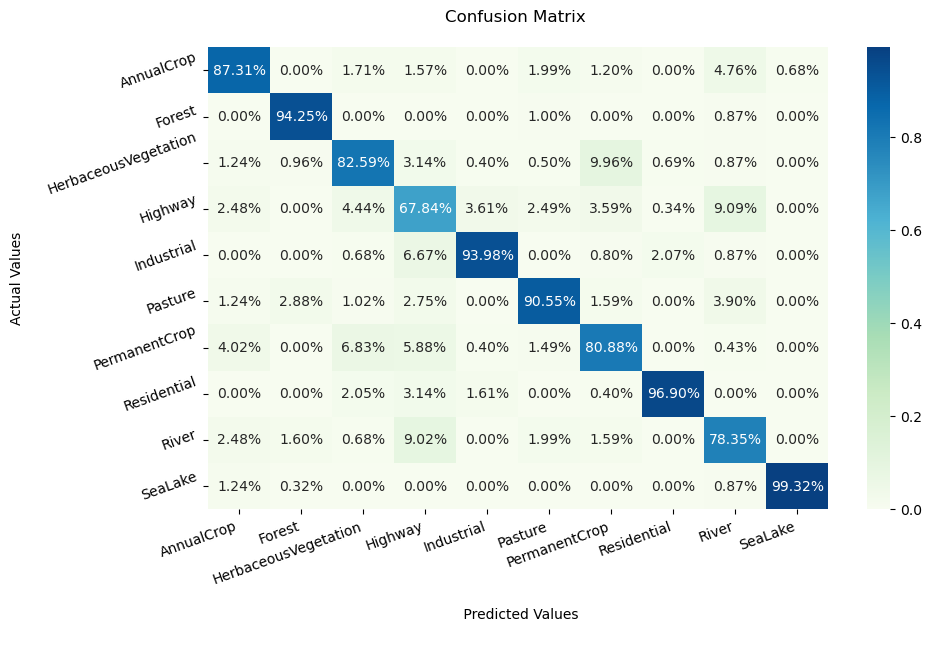

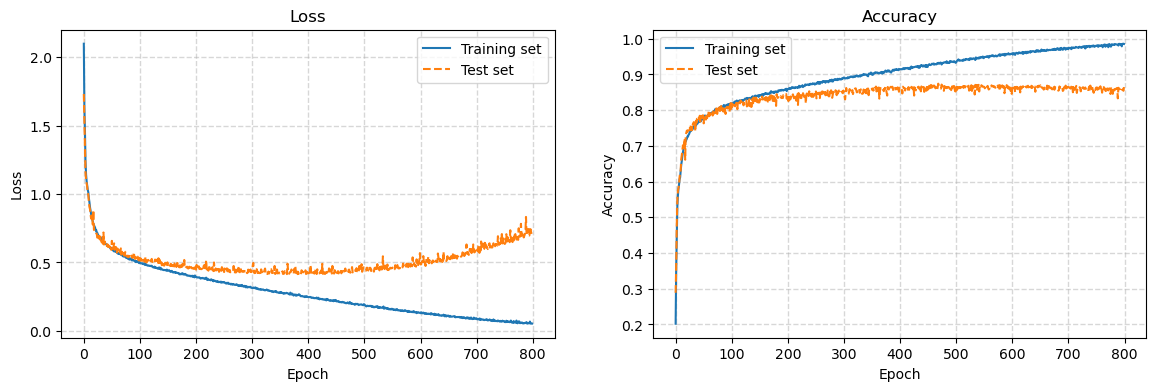

In [12]:
test_loss, test_acc = model.evaluate(ds_test, verbose=0)
print('\nTest accuracy:', test_acc)


ds_test_predict = model.predict(ds_test, verbose=0)

labels_iterator = ds_test.unbatch().map(lambda x, y: y).as_numpy_iterator()
labels = np.array(list(labels_iterator))

y_pred = np.argmax(ds_test_predict, axis=1)
y_test = labels
plt.figure(figsize=(10,6))
fx=sns.heatmap(confusion_matrix(y_pred, y_test, normalize="pred"), annot=True, fmt=".2%",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(['AnnualCrop','Forest','HerbaceousVegetation',
                         'Highway','Industrial','Pasture','PermanentCrop',
                         'Residential','River','SeaLake'], rotation=20, ha="right")
fx.yaxis.set_ticklabels(['AnnualCrop','Forest','HerbaceousVegetation',
                         'Highway','Industrial','Pasture','PermanentCrop',
                         'Residential','River','SeaLake'], rotation=20, ha="right")

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
plt.savefig(fname="convolutedRGB/convolutedRGB confusion matrix"+current_time,dpi=300)
render_training_history(history)
